# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1oLJ2nBVeriGBzqZmRMsEv52ifIyaFHMU?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/ColabNotebooks/Lab3_Gestures_Summer

/content/gdrive/MyDrive/ColabNotebooks/Lab3_Gestures_Summer


In [ ]:
transform =  transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ])
dir = '/content/gdrive/MyDrive/ColabNotebooks/Lab3_Gestures_Summer'
dataset = datasets.ImageFolder(root = dir, transform=transform)

train_size = int(0.6* len(dataset))
val_size = int(0.2* len(dataset))
test_size = len(dataset) - train_size - val_size

classes = ['A','B','C','D','E','F','G','H','I']

#data spilt
train_dataset , val_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,val_size,test_size])

print("The Training dataset size:",train_size)
print("The Training dataset size:",val_size)
print("The Training dataset size:",test_size)

The Training dataset size: 1331
The Training dataset size: 443
The Training dataset size: 445


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class Gesture_CNN(nn.Module):
  def __init__(self):
      super(Gesture_CNN,self).__init__()
      self.name = "Gesture"
      self.conv1 = nn.Conv2d(3, 5, 5) #RGB 3 Channels inputt channel , 5x5 kernel size
      self.pool = nn.MaxPool2d(2, 2) #2x2 max pooling
      self.conv2 = nn.Conv2d(5, 10, 5) #conv layer 10filter 5x5
      self.fc1 = nn.Linear(10 * 53 * 53, 32) # got 53 from output size computation formula (lec.notes)
      self.fc2 = nn.Linear(32, 9) # 9 output because 9 channnels

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

I choose 2 convolutional layers, max pooling layer (2,2), used relu activation function and 2 fully connected layer. Similar to lab2 approach.
size of output dimension computed using output size computation formula.

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_accuracy(model,data,batch_size ): #referred tut3


    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
           imgs = imgs.cuda()
           labels = labels.cuda()
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, batch_size , num_epochs,lr): #referred tut3
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
                  # save the current training information



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            # Append mini-batch accuracy for the training curve
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            on: ",n,'iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_dataset, batch_size))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("IteratiProgress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, data, batch_size))
    val_acc.append(get_accuracy(model, val_dataset, batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    torch.save(model.state_dict(), f'{model.name}_bs{batch_size}_lr{lr}_epoch{num_epochs}')

I choose Cross Entropy Loss function because it is used for multi-classfication problem as we look for 9 gestures.
And the optimizer , SGD(Stochastic Gradient Descent) with momentum helps accelerate SGD in the relevant direction and dampens osscilation, increases for dimen whose gradients point in the same directions and reduces update for dimens whose gradients change direction.(referred lecture notes)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def train_small(model, data, batch_size , num_epochs):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc = [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
                  # save the current training information



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            # Append mini-batch accuracy for the training curve
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.xlabel("Iterations")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, data, batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))

    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.50  % Time Elapsed:   0.33 s 
Epoch 0 Finished.  Time per Epoch:   0.33 s 
Iteration:  2 Progress:   1.00  % Time Elapsed:   0.64 s 
Epoch 1 Finished.  Time per Epoch:   0.32 s 
Iteration:  3 Progress:   1.50  % Time Elapsed:   0.97 s 
Epoch 2 Finished.  Time per Epoch:   0.32 s 
Iteration:  4 Progress:   2.00  % Time Elapsed:   1.30 s 
Epoch 3 Finished.  Time per Epoch:   0.33 s 
Iteration:  5 Progress:   2.50  % Time Elapsed:   1.62 s 
Epoch 4 Finished.  Time per Epoch:   0.32 s 
Iteration:  6 Progress:   3.00  % Time Elapsed:   1.94 s 
Epoch 5 Finished.  Time per Epoch:   0.32 s 
Iteration:  7 Progress:   3.50  % Time Elapsed:   2.27 s 
Epoch 6 Finished.  Time per Epoch:   0.32 s 
Iteration:  8 Progress:   4.00  % Time Elapsed:   2.58 s 
Epoch 7 Finished.  Time per Epoch:   0.32 s 
Iteration:  9 Progress:   4.50  % Time Elapsed:   3.32 s 
Epoch 8 Finished.  Time per Epoch:   0.37 s 
Iteration:  10 Progress:   5.

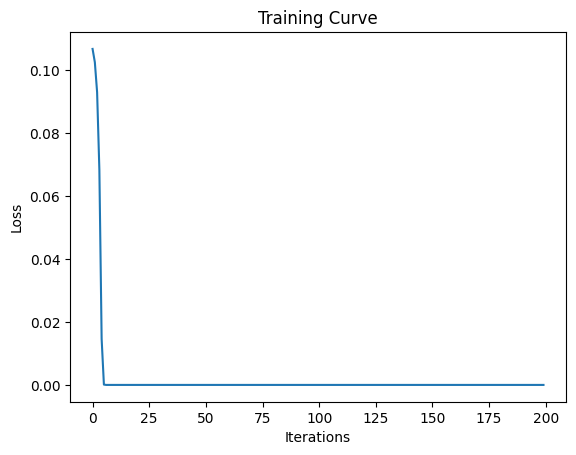

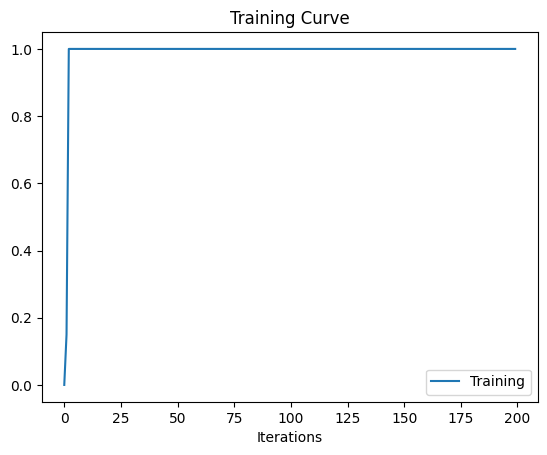

Final Training Accuracy: 1.0
Total time:   71.57 s  Time per Epoch:   0.36 s 


In [ ]:
use_cuda = True
from torch.utils.data import Subset, DataLoader
small_dataset = Subset(dataset, list(range(20)))
small_loader = DataLoader(small_dataset, batch_size=20, shuffle=True)
model = Gesture_CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train_small(model,small_dataset,batch_size=20, num_epochs=200)

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
#Batch Size, Learning Rate, Number of layers CNN

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.24  % Time Elapsed:   7.15 s 
Iteration:  2 Progress:   0.48  % Time Elapsed:  14.57 s 
Iteration:  3 Progress:   0.71  % Time Elapsed:  21.84 s 
Iteration:  4 Progress:   0.95  % Time Elapsed:  29.00 s 
Iteration:  5 Progress:   1.19  % Time Elapsed:  36.48 s 
Iteration:  6 Progress:   1.43  % Time Elapsed:  43.34 s 
Iteration:  7 Progress:   1.67  % Time Elapsed:  51.07 s 
Iteration:  8 Progress:   1.90  % Time Elapsed:  57.93 s 
Iteration:  9 Progress:   2.14  % Time Elapsed:  65.62 s 
Iteration:  10 Progress:   2.38  % Time Elapsed:  72.40 s 
Iteration:  11 Progress:   2.62  % Time Elapsed:  80.09 s 
Iteration:  12 Progress:   2.86  % Time Elapsed:  86.82 s 
Iteration:  13 Progress:   3.10  % Time Elapsed:  94.39 s 
Iteration:  14 Progress:   3.33  % Time Elapsed:  101.08 s 
Iteration:  15 Progress:   3.57  % Time Elapsed:  108.72 s 
Iteration:  16 Progress:   3.81  % Time Elapsed:  115.44 s 
Iteration:  17 Pro

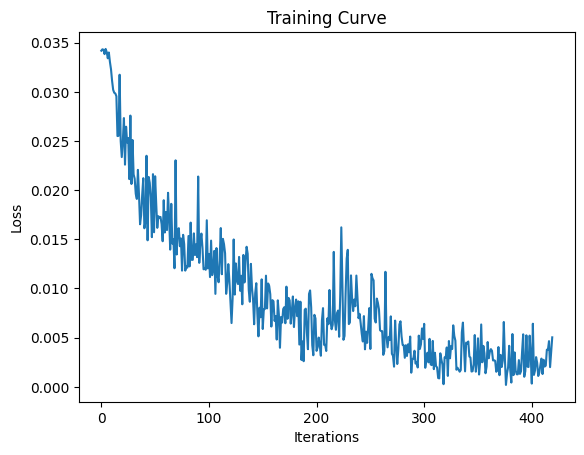

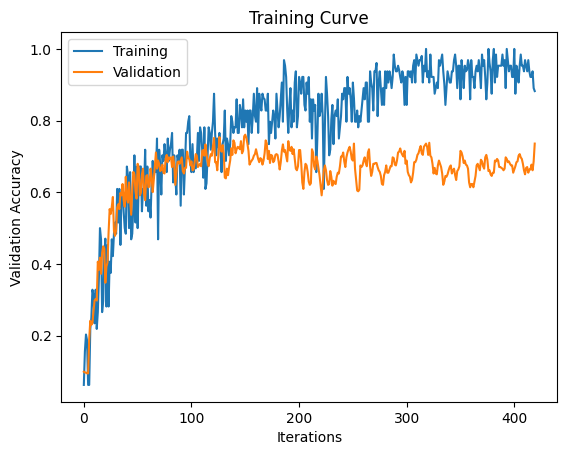

Final Training Accuracy: 0.9691960931630353
Final Validation Accuracy: 0.7358916478555305
Total time:   2958.91 s  Time per Epoch:  147.95 s 


In [ ]:
use_cuda = True
model = Gesture_CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_dataset,batch_size=64, num_epochs=20, lr=0.02)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.83  % Time Elapsed:  12.70 s 
Iteration:  2 Progress:   1.67  % Time Elapsed:  24.33 s 
Iteration:  3 Progress:   2.50  % Time Elapsed:  36.31 s 
Iteration:  4 Progress:   3.33  % Time Elapsed:  48.75 s 
Iteration:  5 Progress:   4.17  % Time Elapsed:  62.52 s 
Iteration:  6 Progress:   5.00  % Time Elapsed:  70.17 s 
Epoch 0 Finished.  Time per Epoch:  70.17 s 
Iteration:  7 Progress:   5.83  % Time Elapsed:  82.64 s 
Iteration:  8 Progress:   6.67  % Time Elapsed:  94.62 s 
Iteration:  9 Progress:   7.50  % Time Elapsed:  106.36 s 
Iteration:  10 Progress:   8.33  % Time Elapsed:  118.61 s 
Iteration:  11 Progress:   9.17  % Time Elapsed:  131.06 s 
Iteration:  12 Progress:  10.00  % Time Elapsed:  138.75 s 
Epoch 1 Finished.  Time per Epoch:  69.38 s 
Iteration:  13 Progress:  10.83  % Time Elapsed:  151.08 s 
Iteration:  14 Progress:  11.67  % Time Elapsed:  163.11 s 
Iteration:  15 Progress:  12.50  % Time Ela

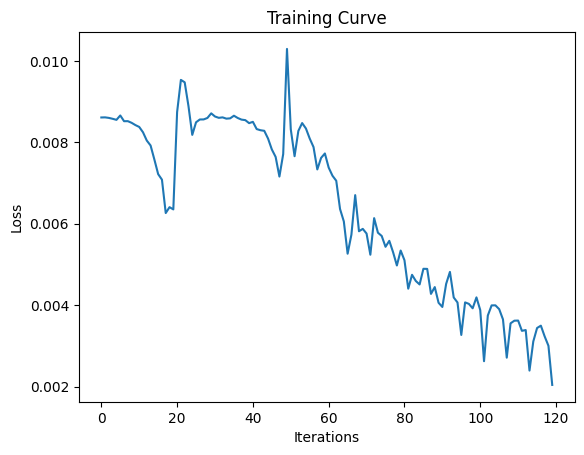

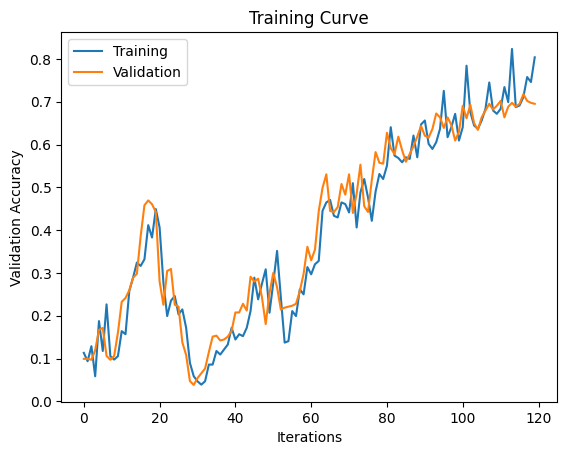

Final Training Accuracy: 0.7182569496619083
Final Validation Accuracy: 0.6952595936794582
Total time:   1358.42 s  Time per Epoch:  67.92 s 


In [ ]:
#Batch Size changed to 256
use_cuda = True
model = Gesture_CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train(model,train_dataset,batch_size=256, num_epochs=20, lr=0.02)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.83  % Time Elapsed:  12.19 s 
Iteration:  2 Progress:   1.67  % Time Elapsed:  24.50 s 
Iteration:  3 Progress:   2.50  % Time Elapsed:  36.72 s 
Iteration:  4 Progress:   3.33  % Time Elapsed:  48.86 s 
Iteration:  5 Progress:   4.17  % Time Elapsed:  60.60 s 
Iteration:  6 Progress:   5.00  % Time Elapsed:  67.81 s 
Epoch 0 Finished.  Time per Epoch:  67.81 s 
Iteration:  7 Progress:   5.83  % Time Elapsed:  80.18 s 
Iteration:  8 Progress:   6.67  % Time Elapsed:  92.61 s 
Iteration:  9 Progress:   7.50  % Time Elapsed:  104.95 s 
Iteration:  10 Progress:   8.33  % Time Elapsed:  117.11 s 
Iteration:  11 Progress:   9.17  % Time Elapsed:  128.77 s 
Iteration:  12 Progress:  10.00  % Time Elapsed:  136.04 s 
Epoch 1 Finished.  Time per Epoch:  68.02 s 
Iteration:  13 Progress:  10.83  % Time Elapsed:  148.22 s 
Iteration:  14 Progress:  11.67  % Time Elapsed:  160.47 s 
Iteration:  15 Progress:  12.50  % Time Ela

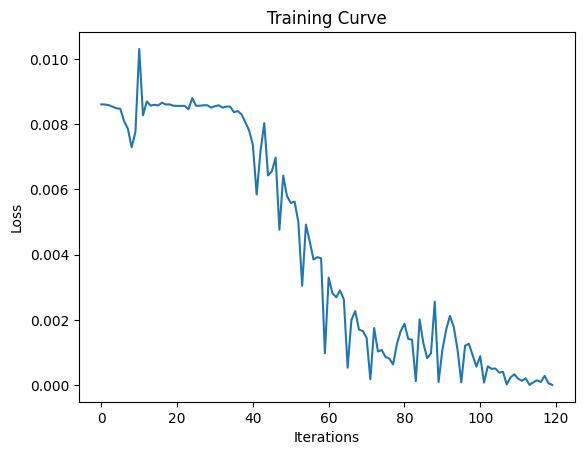

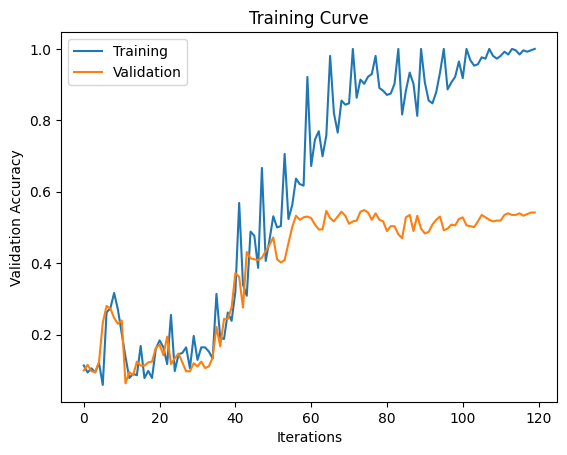

Final Training Accuracy: 0.9969947407963937
Final Validation Accuracy: 0.5417607223476298
Total time:   1364.24 s  Time per Epoch:  68.21 s 


In [ ]:
#lr change to 0.07
use_cuda = True
model = Gesture_CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_dataset,batch_size=256, num_epochs=20, lr=0.07)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.48  % Time Elapsed:   6.19 s 
Iteration:  2 Progress:   0.95  % Time Elapsed:  11.50 s 
Iteration:  3 Progress:   1.43  % Time Elapsed:  17.60 s 
Iteration:  4 Progress:   1.90  % Time Elapsed:  23.00 s 
Iteration:  5 Progress:   2.38  % Time Elapsed:  28.68 s 
Iteration:  6 Progress:   2.86  % Time Elapsed:  34.73 s 
Iteration:  7 Progress:   3.33  % Time Elapsed:  40.13 s 
Iteration:  8 Progress:   3.81  % Time Elapsed:  46.32 s 
Iteration:  9 Progress:   4.29  % Time Elapsed:  51.59 s 
Iteration:  10 Progress:   4.76  % Time Elapsed:  57.28 s 
Iteration:  11 Progress:   5.24  % Time Elapsed:  63.04 s 
Iteration:  12 Progress:   5.71  % Time Elapsed:  68.36 s 
Iteration:  13 Progress:   6.19  % Time Elapsed:  74.45 s 
Iteration:  14 Progress:   6.67  % Time Elapsed:  79.77 s 
Iteration:  15 Progress:   7.14  % Time Elapsed:  85.67 s 
Iteration:  16 Progress:   7.62  % Time Elapsed:  91.40 s 
Iteration:  17 Progre

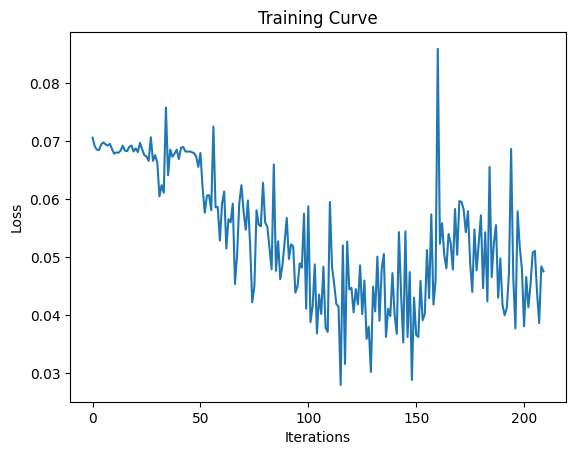

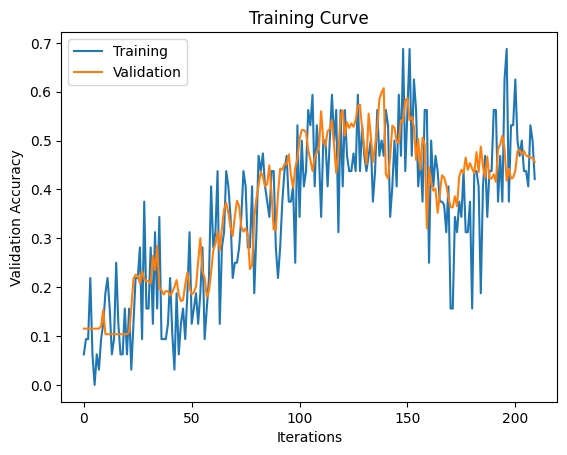

Final Training Accuracy: 0.48084147257700977
Final Validation Accuracy: 0.45598194130925507
Total time:   1179.82 s  Time per Epoch:  235.96 s 


In [ ]:
class Gesture_CNN_new(nn.Module):
  def __init__(self):
      super(Gesture_CNN_new,self).__init__()
      self.name = "Gesture"
      self.conv1 = nn.Conv2d(3, 5, 5) #RGB 3 Channels , 5x5 kernel size
      self.pool = nn.MaxPool2d(2, 2) #2x2 max pooling
      self.conv2 = nn.Conv2d(5, 10, 5) #conv layer 10filter 5x5
      self.conv3 = nn.Conv2d(10, 15, 5) #conv layer 15filter 5x5
      self.fc1 = nn.Linear(15 * 24 * 24, 32)
      self.fc2 = nn.Linear(32, 16)
      self.fc3 = nn.Linear(16, 9)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 15 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

use_cuda = True
model = Gesture_CNN_new()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_dataset,batch_size=32, num_epochs=5, lr=0.04)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
#The best model performance I got was from the first model,
#with these hyperparameters:
#batch_size=64, #num_epochs=20, lr=0.02, 2 CNN layers

#best results I obtained:
#Final Training Accuracy: 0.9691960931630353 (96.9%)
#Final Validation Accuracy: 0.7358916478555305 (73.6%)

#Although the other model has higher training accuracy however, performance
#on the validation accuracy is more important
#Final Training Accuracy: 0.9969947407963937 (99.7%)
#Final Validation Accuracy: 0.5417607223476298


### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
final_model = Gesture_CNN()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
final_model.load_state_dict(torch.load('Gesture_bs64_lr0.02_epoch20'))
correct = 0
total = 0
batch_size = 64
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
for imgs, labels in torch.utils.data.DataLoader(test_dataset, batch_size=batch_size):
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
           imgs = imgs.cuda()
           labels = labels.cuda()
        output = final_model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
print("Test Accuracy: ",correct/total)

CUDA is not available.  Training on CPU ...
Test Accuracy:  0.8539325842696629


Test Accuracy: 0.8539 (85.4%)

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 91.3MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
#features = alexnet.features(images)


**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
path = '/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures'
os.makedirs(path, exist_ok=True)
path = '/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/train'
os.makedirs(path, exist_ok=True)
path = '/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/val'
os.makedirs(path, exist_ok=True)
path = '/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/test'
os.makedirs(path, exist_ok=True)


In [ ]:
  # img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
  # define dataloader parameters
classes = ['A','B','C','D','E','F','G','H','I']

for subdir in classes:
      path = f'/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/train/{subdir}'
      os.makedirs(path, exist_ok=True)
      path = f'/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/val/{subdir}'
      os.makedirs(path, exist_ok=True)
      path = f'/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/test/{subdir}'
      os.makedirs(path, exist_ok=True)


i = 0
  # img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
  # define dataloader parameters
batch_size  = 1 #with batchsize >1 was not wrking would need like anther loopp
num_workers =0
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                            num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            num_workers=num_workers, shuffle=True)
  # obtain one batch of training images
  #dataiter = iter(train_loader)
  #images, labels = next(dataiter)
  #images = images.numpy() # convert images to numpy for display
alex_train , alex_val, alex_test = [],[],[]

i = 0
for imgs,labels in train_loader:
        features = alexnet.features(imgs)
        class_label = classes[labels.item()]
        torch.save(features.squeeze(0).detach(), f'/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/train/{class_label}/train_feature{i}.tensor')
        #alex_train.append(features.detach().numpy())
        i += 1

i1 = 0
for imgs,labels in val_loader:
      features = alexnet.features(imgs)
      class_label = classes[labels.item()]
      torch.save(features.squeeze(0).detach(), f'/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/val/{class_label}/val_feature{i1}.tensor')
      i1 += 1

i2 = 0
for imgs,labels in test_loader:
      features = alexnet.features(imgs)
      class_label = classes[labels.item()]
      torch.save(features.squeeze(0).detach(),f'/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/test/{class_label}/test_feature{i2}.tensor')
      i2 += 1





### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
#output = model(features)
#prob = F.softmax(output)

In [ ]:
class Gesture_Alex(nn.Module):
  def __init__(self):
      super(Gesture_Alex,self).__init__()
      self.name = "Gesture_Alex"
      self.fc1 = nn.Linear(256 * 6 * 6, 32) #Nx256x6x6
      self.fc2 = nn.Linear(32, 9)

  def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The Gesture Alex Architecture i choose is fully connected neural network arch(ANN), 2 linear layers, alexNet has CNN features already.No pooling layer.Layer1 used activation function ReLU, and output of layer 2 is 9 gesture classes.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
#tensor = torch.from_numpy(tensor.detach().numpy())

In [ ]:
def train(model,train_loader,val_loader, batch_size , num_epochs,lr):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
                  # save the current training information



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            # Append mini-batch accuracy for the training curve
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    val_acc.append(get_accuracy(model, val_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    torch.save(model.state_dict(), f'{model.name}_bs{batch_size}_lr{lr}_epoch{num_epochs}')

In [ ]:
def get_accuracy(model,data_loader ):


    correct = 0
    total = 0
    for imgs, labels in data_loader:
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
           imgs = imgs.cuda()
           labels = labels.cuda()
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.12  % Time Elapsed:   2.20 s 
Iteration:  2 Progress:   0.25  % Time Elapsed:   4.27 s 
Iteration:  3 Progress:   0.38  % Time Elapsed:   6.51 s 
Iteration:  4 Progress:   0.50  % Time Elapsed:   8.77 s 
Iteration:  5 Progress:   0.62  % Time Elapsed:  10.84 s 
Iteration:  6 Progress:   0.75  % Time Elapsed:  13.09 s 
Iteration:  7 Progress:   0.88  % Time Elapsed:  15.46 s 
Iteration:  8 Progress:   1.00  % Time Elapsed:  17.77 s 
Iteration:  9 Progress:   1.12  % Time Elapsed:  20.00 s 
Iteration:  10 Progress:   1.25  % Time Elapsed:  22.03 s 
Iteration:  11 Progress:   1.38  % Time Elapsed:  24.38 s 
Iteration:  12 Progress:   1.50  % Time Elapsed:  26.53 s 
Iteration:  13 Progress:   1.62  % Time Elapsed:  28.79 s 
Iteration:  14 Progress:   1.75  % Time Elapsed:  31.19 s 
Iteration:  15 Progress:   1.88  % Time Elapsed:  33.47 s 
Iteration:  16 Progress:   2.00  % Time Elapsed:  35.64 s 
Iteration:  17 Progre

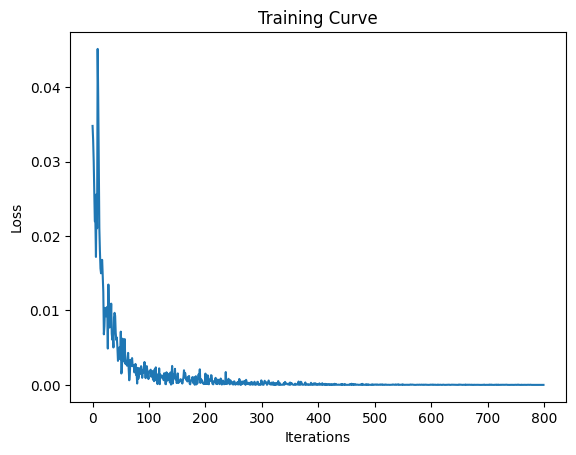

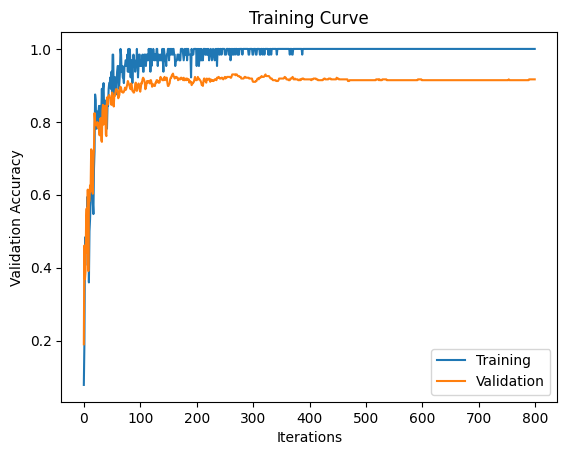

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9164785553047404
Total time:   1606.70 s  Time per Epoch:  80.33 s 


In [ ]:
use_cuda = True
model = Gesture_Alex()
train_feature_dataset = datasets.DatasetFolder( '/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/train', loader=torch.load, extensions='.tensor')
val_feature_dataset = datasets.DatasetFolder('/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/val', loader=torch.load, extensions='.tensor')
test_features_dataset= datasets.DatasetFolder('/content/gdrive/MyDrive/ColabNotebooks/Lab3_AlexNetFeatures/test', loader=torch.load, extensions='.tensor')

train_loader_feature = torch.utils.data.DataLoader(train_feature_dataset, batch_size=64, shuffle=True)
val_loader_feature = torch.utils.data.DataLoader(val_feature_dataset, batch_size=64, shuffle=True)
test_loader_feature = torch.utils.data.DataLoader(test_features_dataset, batch_size=64, shuffle=True)
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_loader_feature,val_loader_feature,batch_size=64, num_epochs=20, lr=0.02)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.24  % Time Elapsed:   0.16 s 
Iteration:  2 Progress:   0.48  % Time Elapsed:   0.18 s 
Iteration:  3 Progress:   0.71  % Time Elapsed:   0.20 s 
Iteration:  4 Progress:   0.95  % Time Elapsed:   0.22 s 
Iteration:  5 Progress:   1.19  % Time Elapsed:   0.24 s 
Iteration:  6 Progress:   1.43  % Time Elapsed:   0.26 s 
Iteration:  7 Progress:   1.67  % Time Elapsed:   0.27 s 
Iteration:  8 Progress:   1.90  % Time Elapsed:   0.29 s 
Iteration:  9 Progress:   2.14  % Time Elapsed:   0.31 s 
Iteration:  10 Progress:   2.38  % Time Elapsed:   0.33 s 
Iteration:  11 Progress:   2.62  % Time Elapsed:   0.35 s 
Iteration:  12 Progress:   2.86  % Time Elapsed:   0.37 s 
Iteration:  13 Progress:   3.10  % Time Elapsed:   0.39 s 
Iteration:  14 Progress:   3.33  % Time Elapsed:   0.41 s 
Iteration:  15 Progress:   3.57  % Time Elapsed:   0.43 s 
Iteration:  16 Progress:   3.81  % Time Elapsed:   0.44 s 
Iteration:  17 Progre

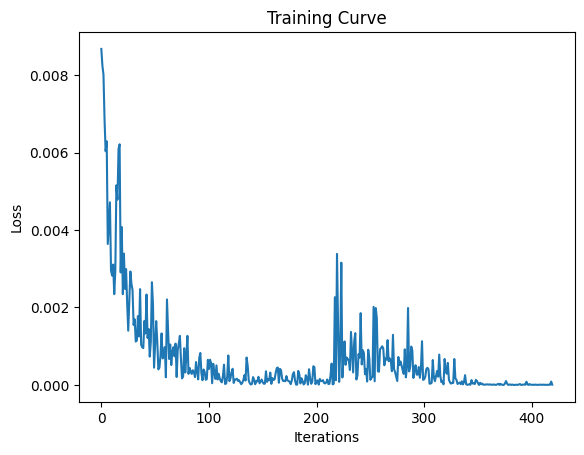

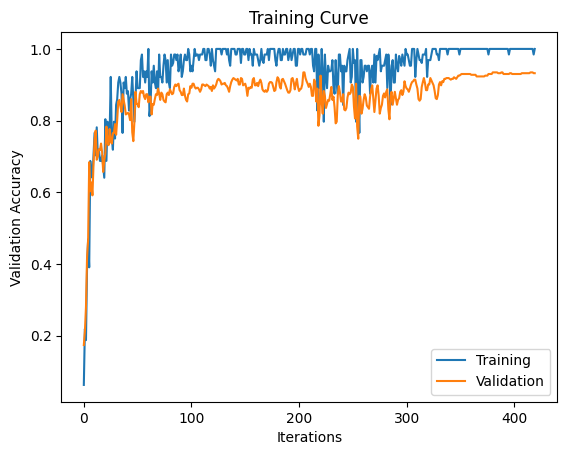

Final Training Accuracy: 0.9992486851990984
Final Validation Accuracy: 0.9322799097065463
Total time:    8.93 s  Time per Epoch:   0.45 s 


In [ ]:

#ALNC = alexnet.features

use_cuda = True
model = Gesture_Alex()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_loader_feature,val_loader_feature,batch_size=256, num_epochs=20, lr=0.02)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.24  % Time Elapsed:   0.02 s 
Iteration:  2 Progress:   0.48  % Time Elapsed:   0.04 s 
Iteration:  3 Progress:   0.71  % Time Elapsed:   0.06 s 
Iteration:  4 Progress:   0.95  % Time Elapsed:   0.08 s 
Iteration:  5 Progress:   1.19  % Time Elapsed:   0.10 s 
Iteration:  6 Progress:   1.43  % Time Elapsed:   0.12 s 
Iteration:  7 Progress:   1.67  % Time Elapsed:   0.14 s 
Iteration:  8 Progress:   1.90  % Time Elapsed:   0.17 s 
Iteration:  9 Progress:   2.14  % Time Elapsed:   0.19 s 
Iteration:  10 Progress:   2.38  % Time Elapsed:   0.21 s 
Iteration:  11 Progress:   2.62  % Time Elapsed:   0.23 s 
Iteration:  12 Progress:   2.86  % Time Elapsed:   0.25 s 
Iteration:  13 Progress:   3.10  % Time Elapsed:   0.27 s 
Iteration:  14 Progress:   3.33  % Time Elapsed:   0.29 s 
Iteration:  15 Progress:   3.57  % Time Elapsed:   0.31 s 
Iteration:  16 Progress:   3.81  % Time Elapsed:   0.33 s 
Iteration:  17 Progre

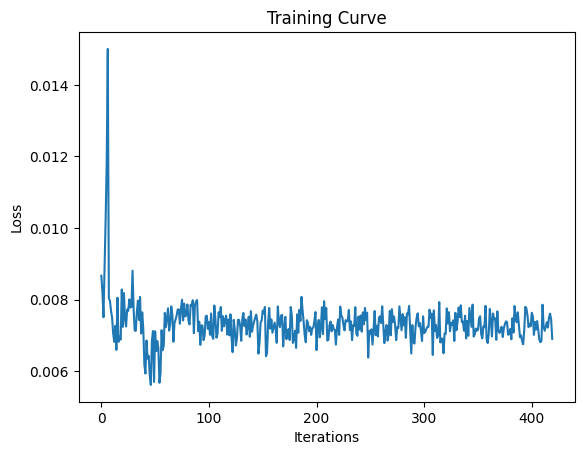

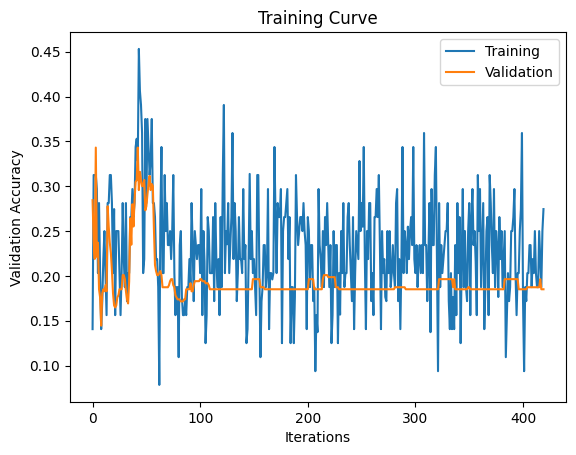

Final Training Accuracy: 0.2336589030803907
Final Validation Accuracy: 0.18510158013544017
Total time:    8.59 s  Time per Epoch:   0.43 s 


In [ ]:

#ALNC = alexnet.features

use_cuda = True
model = Gesture_Alex()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model,train_loader_feature,val_loader_feature,batch_size=256, num_epochs=20, lr=0.07)

The best model is batch_size=256, num_epochs=20, lr=0.02 with results:

Final Training Accuracy: 0.9992486851990984

Final Validation Accuracy: 0.9322799097065463


### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
final_model = Gesture_Alex()
test_loader = torch.utils.data.DataLoader(test_loader_feature, batch_size=256, shuffle=True)
#batch_size=256, num_epochs=20, lr=0.02)

final_model.load_state_dict(torch.load('Gesture_Alex_bs256_lr0.02_epoch20'))
correct = 0
total = 0
batch_size = 64
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
for imgs, labels in torch.utils.data.DataLoader(test_features_dataset, batch_size=batch_size):
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
           imgs = imgs.cuda()
           labels = labels.cuda()
        output = final_model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
print("Test Accuracy: ",correct/total)

CUDA is not available.  Training on CPU ...
Test Accuracy:  0.9393258426966292


The Test Accuracy: 0.9393 (93.9%) with transfer learning is compared to Part3(d) Test Accuracy:  0.8539325842696629 (85.4%).
The Gesture Alex model is (8.5%) percent better.

In [ ]:
!jupyter nbconvert --to html /content/gdrive/MyDrive/ColabNotebooks/Lab3GestureRecognition.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/ColabNotebooks/Lab3GestureRecognition.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 16 image(s).
[NbConvertApp] Writing 1449459 bytes to /content/gdrive/MyDrive/ColabNotebooks/Lab3GestureRecognition.html
